**NAME:**
Eric Graham


# In Class Assignment 2

### Loading the Classification Data
Please run the following code to read in the "digits" dataset from sklearn's data loading module. This is identical to the first in class assignment for loading the data into matrices. `ds.data` is a matrix of feature values and `ds.target` is a column vector of the class output (in our case, the hand written digit we want to classify). Each class is a number (0 through 9) that we want to classify as one of ten hand written digits.

In [1]:
from sklearn.datasets import load_digits
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

ds = load_digits()

# this holds the continuous feature data
print('features shape:', ds.data.shape) # there are 1797 instances and 64 features per instance
print('target shape:', ds.target.shape )
print('range of target:', np.min(ds.target),np.max(ds.target))

features shape: (1797, 64)
target shape: (1797,)
range of target: 0 9


### Using Decision Trees
In the videos, we talked about the splitting conditions for different attributes. Specifically, we discussed the number of ways in which it is possible to split a node, depending on the attribute types. To understand the possible splits, we need to understand the attributes. For the question below, you might find the description in the `ds['DESCR']` field to be useful. You can see the field using `print(ds['DESCR'])`

**Question 1:** For the digits dataset, what are the type(s) of the attributes? How many attributes are there? What do they represent?

**Answer:** The digits dataset includes 64 floating point attributes. According to the description, the original 32x32 bitmap images of the hand-drawn numbers ranging from 0-9 were divided into 4x4 blocks. 

These blocks were then converted(?) into an 8x8 matrix with integer values ranging from 0-16 based on the pixel intensity of each block. This matrix gives us a numeric expression of the "shape" of the original image, which we can then use to try to classify which numeral each hand-drawn image represents. 

Note that while the values are stored as float64 this was likely done for computational purposes, the actual values are integers (according to the description).

In [2]:
print(ds.data.dtype)

float64


In [3]:
## Enter any code here
print(ds['DESCR'])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 1797
:Number of Attributes: 64
:Attribute Information: 8x8 image of integer pixels in the range 0..16.
:Missing Attribute Values: None
:Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
:Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an in

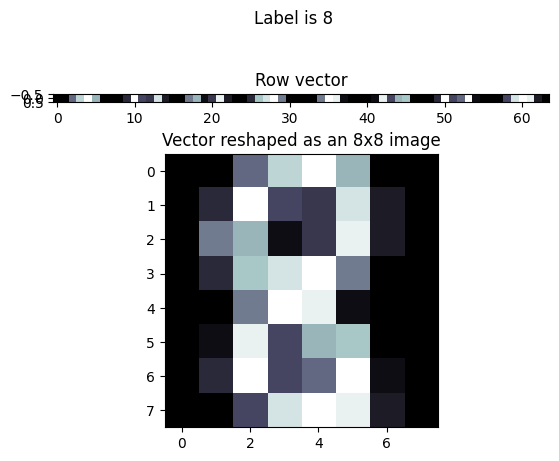

In [4]:
#get the vector data from a random position
idx = np.random.randint(0,len(ds.target))
raw_row = ds.data[idx] # as a vector
img = ds.data[idx].reshape((8,8)) #reshaped to be an image

#custom plotting tools
gs = gridspec.GridSpec(4,2)

plt.subplot(gs[0,:]) #show vector
plt.imshow(np.matrix(raw_row), cmap=plt.cm.bone, interpolation='nearest')
plt.title('Row vector')

plt.subplot(gs[1:,:]) #show image
plt.imshow(img, cmap=plt.cm.bone, interpolation='nearest')
plt.title('Vector reshaped as an 8x8 image')

plt.suptitle('Label is %d'%(ds.target[idx]))

plt.show()

### Using the gini coefficient
We talked about the gini index in the videos.  The Gini coefficient for a **given split** is given by:
$$Gini=\sum_{t=1}^T \frac{n_t}{N}gini(t)$$
where $T$ is the total number of splits (2 for binary attributes), $n_t$ is the number of instances in node $t$ after splitting, and $N$ is the total number of instances in the parent node. $gini(t)$ is the **gini index for each individual node that is created by the split** and is given by:
$$gini(t)=1-\sum_{j=0}^{C-1} p(j|t)^2$$
where $C$ is the total number of possible classes and $p(j|t)$ is the probability of class $j$ in node $t$ (i.e., $n_j==$ the count of instances belonging to class $j$ in node $t$, normalized by the total number of instances in node $t$).
$$ p(j|t) = \frac{n_j}{n_t}$$

For the given dataset, $gini(t)$ has been programmed for you in the function `gini_index`.

* `def gini_index(classes_in_split):`
 * To use the function, pass in a `numpy` array of the class labels for a node as (i.e., pass in the rows from `ds.target` that make up a node in the tree) and the gini will be returned for that node.

In [5]:
# compute the gini of several examples for the starting dataset
# This function "gini_index" is written for you. Once you run this block, you
#   will have access to the function for the notebook. You do not need to know
#   how this function works--only what it returns
# This function returns the gini index for an array of classes in a node.
def gini_index(classes_in_split):
    # pay no attention to this code in the function-- it just computes the gini for a given split
    classes_in_split = np.reshape(classes_in_split,(len(classes_in_split),-1))
    unique_classes = np.unique(classes_in_split)
    gini = 1
    for c in unique_classes:
        gini -= (np.sum(classes_in_split==c) / float(len(classes_in_split)))**2

    return gini

In the example below, the function is used calculate the gini for splitting the dataset on feature 28, with value 2.5. In this example, we need to create two separate tree nodes: the first node has all the `ds.target` labels when feature 28 is greater than 2.5, the second node has all the rows from `ds.target` where feature 28 is less than 2.5. The steps are outlined below. **Read this carefully to understand what the code does below in the block following this.**
- Feature 28 is saved into a separate variable `feature28 = ds.data[:,28]`
- First all the target classes for the first node are calculated using `numpy` indexing `ds.target[feature28>2.5]`
 - Note: this grabs all the rows in `ds.target` (the classes) which have feature 28 greater than 2.5 (similar to indexing in pandas)
- Second, those classes are passed into the function to get the gini for the right node in this split (i.e., feature 28 being greater than the threshold 2.5).
 - `gini_r = gini_index(ds.target[feature28>2.5])`
- Third, the gini is calculated for the left node in the tree. This grabs only the rows in `ds.target` where feature 28 is less than 2.5.
     - `gini_l = gini_index(ds.target[feature28<=2.5])`
- Combining the gini indices is left as an exercise in the next section

In [6]:
#==========================Use the gini_index Example===============
# get the value for this feature as a column vector
# (this is like grabbing one column of the record table)
feature28 = ds.data[:,28]

# if we split on the value of 2.5, then this is the gini for each resulting node:
gini_r = gini_index(ds.target[feature28>2.5]) # just like in pandas, we are sending in the rows where feature28>2.5
gini_l = gini_index(ds.target[feature28<=2.5]) # and sending the rows where feature28<=2.5

# compute gini example. This splits on attribute '28' with a value of 2.5
print('gini for right node of split:', gini_r)
print('gini for left node of split:', gini_l)

gini for right node of split: 0.8845857867667073
gini for left node of split: 0.7115407566535388


Now, using the above values `gini_r` and `gini_l`. Calculate the combined Gini for the entire split. You will need to write the weighted summation (based upon the number of instances inside each node). To count the number of instances greater than a value using numpy, you can use broadcasting, which is a special way of indexing into a numpy array. For example, the code `some_array>5` will return a new numpy array of true/false elements. It is the same size as `some_array` and is marked true where the array is greater than `5`, and false otherwise. By taking the `sum` of this array, we can count how many times `some_array` is greater than `5`.

`counts = sum(some_array>5)`

You will need to use this syntax to count the values in each node as a result of splitting.

In [7]:
feature28 = ds.data[:,28]
float(sum(feature28>2.5))

1398.0

In [8]:
# we need to make a weighted sum of the gini indices
num_instances_r = float(sum(feature28>2.5))
num_instances_l = float(sum(feature28<=2.5))
N = float(len(ds.target))

gini_total = (num_instances_r*gini_r + num_instances_l*gini_l) / N
print('The total gini of the split for a threshold of 2.5 is:',gini_total)

The total gini of the split for a threshold of 2.5 is: 0.8461634345045179


**Question 2:** Now we want to know which of the two is a better split:
- `feature28` split on a value of `2.5`  
- `feature28` split on a value of `10`

Enter your code to find the total gini of splitting on the threshold of 10 and compare it to the total gini of splitting on threshold of 2.5 (for feature 28 only).

According to Gini, which threshold is better for spliting on feature 28, `threshold=2.5` or `threshold=10.0`? Explain.

**Answer:** The threshold of 2.5 produced a slightly lower Gini purity score, which is better because it means there is less mixing of classes in the nodes for feature 28.

In [9]:
# Enter your code here

gini_r = gini_index(ds.target[feature28>10]) # repurposing above code to split feature28>10
gini_l = gini_index(ds.target[feature28<=10]) #  feature28<=10



# Enter your code here

num_instances_r = float(sum(feature28>10))
num_instances_l = float(sum(feature28<=10))
N = float(len(ds.target))

gini_total_10 = (num_instances_r*gini_r + num_instances_l*gini_l) / N

print('The total gini of the split for a threshold of 10 is:',gini_total_10)
print('This is not better than the split on 2.5')

The total gini of the split for a threshold of 10 is: 0.8636111743234274
This is not better than the split on 2.5


### Entropy based splitting
We discussed entropy as well in the video as another means of splitting. We calculated entropy for a node $t$ by:
$$ Entropy(t) = -\sum p(j|t) \log p(j|t) $$
where $p(j|t)$ is the same as above. To combine Entropy measures from a set of nodes, t = {1,...,T} we use:
$$Entropy_{split}=\sum_{t=1}^T \frac{n_t}{N}Entropy(t)$$
where $n_t$ and $N$ are the same as defined above for the $Gini$. Information gain is calculated by subtracting the Entropy of the split from the Entropy of the parent node before splitting:
$$InfoGain = Entropy(p)-Entropy_{split}$$
where $p$ is the parent node before splitting. You are given an equation for calculating the $Entropy(t)$ of  node $t$. It works exactly like the `gini_index` function above, but is named `entropy_value` and returns the entropy for a node. You simply send in an array of the feature values for the node you want to calculate the entropy value for.

In [10]:
def entropy_value(classes_in_split):
    # pay no attention to this code -- it just computes the gini for a given split
    classes_in_split = np.reshape(classes_in_split,(len(classes_in_split),-1))
    unique_classes = np.unique(classes_in_split)
    ent = 0
    for c in unique_classes:
        p = (np.sum(classes_in_split==c) / float(len(classes_in_split)))
        ent += p * np.log(p)

    return -ent

In [11]:
ent_r = entropy_value(ds.target[feature28>2.5])
ent_l = entropy_value(ds.target[feature28<=2.5])

# compute entropy example. This splits on attribute '28' with a value of 2.5
print('entropy for right node of split:', ent_r)
print('entropy for left node of split:', ent_l)

entropy for right node of split: 2.1836975378213057
entropy for left node of split: 1.4898881412786364


**Question 3:** Calculate the **information gain** of the split when the threshold is 2.5 on `feature28`. What is the value of the information gain?

**Answer**: the information gain of the split at threshold 2.5 is 0.27283285132716273

In [12]:
# Enter your code here
ent_parent = entropy_value(ds.target)

num_instances_r = float(sum(feature28>2.5))
num_instances_l = float(sum(feature28<=2.5))
N = float(len(ds.target))

ent_split = (num_instances_r * ent_r + num_instances_l * ent_l) / N

# Enter your code here
info_gain = ent_parent - ent_split
print('The information gain of the split for threshold of 2.5:',info_gain)

The information gain of the split for threshold of 2.5: 0.27283285132716273


**Question 4:** What is the information gain if the threshold is 10.0 on `feature28`? According to information gain, is it better to split on a threshold of 2.5 or 10? Does entropy give the same decision as gini for this example?

**Answer:** The information gain for splitting at a threshold of 10 is .2096, which is lower than that for the threshold 2.5 (.2728). Thus, both entropy and Gini methods agree that 2.5 is the better threshold.

In [13]:
# Enter your code here

ent_r_10 = entropy_value(ds.target[feature28>10])
ent_l_10 = entropy_value(ds.target[feature28<=10])

num_instances_r_10 = float(sum(feature28>10))
num_instances_l_10 = float(sum(feature28<=10))
N = float(len(ds.target))

# Enter your code here

ent_split_10 = (num_instances_r_10 * ent_r_10 + num_instances_l_10 * ent_l_10) / N

# Enter your code here

info_gain_10 = ent_parent - ent_split_10

print('The information gain of the split for threshold of 10:', info_gain_10)
print('This is better than the split on 2.5')
print('This is the same as gini')

The information gain of the split for threshold of 10: 0.20955137704371163
This is/ better than the split on 2.5
This is the same as gini


### Information gain and multi-way splitting
Now assume that we can use not just a binary split, but a three way split.

**Question 5**: What is the information gain if we split feature28 on two thesholds (three separate nodes corresponding to three branches from one node)
- node left: `feature28<2.5`,
- node middle: `2.5<=feature28<10`, and
- node right: `10<=feature28`?

Is the information gain better?

***Note***: You can index into a `numpy` array for the middle node with the following notation: `some_array[(2.5<=feature28) & (feature28<10.0)]`

**Answer**: The information gain of the three-way split (0.3172) is better than those of the 2.5 and 10 splits.

In [14]:
# Enter your code here

ent_left = entropy_value(ds.target[feature28<2.5])
ent_middle = entropy_value(ds.target[(2.5<=feature28) & (feature28<10.0)])
ent_right = entropy_value(ds.target[feature28>=10])

num_instances_left = float(sum(feature28<2.5))
num_instances_middle = float(sum((2.5<=feature28) & (feature28<10.0)))
num_instances_right = float(sum(feature28>=10))
N = float(len(ds.target))

ent_split_3way = (num_instances_left * ent_left + num_instances_middle * ent_middle + num_instances_right * ent_right) / N

info_gain_3way = ent_parent - ent_split_3way

# Enter your code here
print('The information gain of the three way split is:',info_gain_3way)

The information gain of the three way split is: 0.3171890999123379


**Question 6**: Should we normalize the quantity that we just calculated if we want to compare it to the information gain of a binary split? Why or why not? Explain.

**Answer:** Yes, we should normalize that value because more/smaller nodes will tend to be purer (as you approach n nodes, where n is the number of observations, each node will be perfectly pure). So with more splits, information gain will generally increase and we will eventually overfit. 

In [15]:
# Enter your comments here


# Yes, we should normalize that value because more/smaller nodes will tend 
# to be purer (as you approach n nodes, where n is the number of observations, 
# each node will be perfectly pure). So with more splits, information gain will 
# generally increase and we will eventually overfit. 



# Enter your comments here

### Decision Trees in scikit-learn
Scikit-learn also has an implementation of decision trees. Its available here:
- http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

**Question 7**: Read the documention. What algorithm does scikit-learn use for creating decision trees (i.e., ID3, C4.5, C5.0, CART, MARS, CHAID, etc.)?

**Answer:** According to [the docs](https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart) scikit-learn uses "an optimized version of the CART algorithm."

**Question 8**: Using the documentation, use scikit-learn to train a decision tree on the digits data. Calculate the accuracy on the training data. What is the accuracy? Did you expect the decision tree to have this kind of accuracy? Why or why not? Explain.

**Answer**: I got accuracy 1! This was unexpected because that just seems unusually accurate, it feels like we're overfitting. 

In [16]:
# use scikit learn to train a decision tree
from sklearn.tree import DecisionTreeClassifier

# enter your code below here to train and predict on the same data

dt = DecisionTreeClassifier()
dt.fit(ds.data, ds.target)
y_pred = dt.predict(ds.data)

# enter your code above here

from sklearn.metrics import accuracy_score

# enter your code below here to calculate accuracy

accuracy = accuracy_score(ds.target, y_pred)


print('accuracy:', accuracy)
print('I did not expect an accuracy of 1.0 because that is unusually accurate, it feels like we are overfitting!')
# enter your code above here

accuracy: 1.0
I did not expect an accuracy of 1.0 because that is unusually accurate, it feels like we are overfitting!


**Question 9**: Look at the other input parameters to the function `DecisionTreeClassifier`-- could any of them be used to help prevent the decision tree from overlearning on the data?

Which variables might we use to control overfitting and how (explain why it might help to stop overfitting)?

**Answer:** The most useful seem to be:

* max_depth: by limiting the depth of the tree, we can prevent multiple splits which would effectively "memorize" the training data. In theory, a tree with no depth constraints would just be a flow-chart mapping the outcomes of the training data.
* min_samples_split: nodes with very small samples are more likely to be pure by random chance, so requiring a minimum number of samples per node would prevent overfitting by making node samples more representative of general patterns in the data

________________________________________________________________________________________________________

That's all! Please **upload your rendered notebook** (.ipynb file!).
Also please remember to save the notebook before uploading.



Grading Schema:

Q1: 5;

Q2: 15;

Q3: 10;

Q4: 10;

Q5: 10;

Q6: 15

Q7: 10

Q8: 15

Q9: 10